#Thông tin sinh viên
- Họ tên: Nguyễn Thị Như Vân
- MSSV: 20520855
- Bài tập 1: 26/09/2022

# Kết nối với Google Drive

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Import thư viện

In [6]:
import torch
import torchvision
from torchvision import datasets
from imutils import paths
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import cv2
import numpy as np	

Download dataset

In [7]:
data_path='./'
dataset =  datasets.Caltech101(data_path, download=True)


Files already downloaded and verified


Extract Feature histogram

In [8]:
image_paths = list(paths.list_images('./caltech101'))

data = []
labels = []
for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]
    if label == "BACKGROUND_Google":
        continue
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    size = img.shape[0]*img.shape[1]
    hist = hist/size

    data.append(hist)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)



100%|██████████| 9144/9144 [00:07<00:00, 1175.32it/s]


Encode label

In [9]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 101


Split data

In [10]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

x_train = x_train.reshape(len(x_train), 256)
x_val = x_val.reshape(len(x_val), 256)
x_test = x_test.reshape(len(x_test), 256)
print(len(x_train))
print(len(x_val))
print(len(x_test))


5206
1735
1736


# Yêu cầu 1:
Áp dụng thuật toán KNN, tính Accuracy trên tập val và test với các giá trị k lần lượt:1,2,3,4,5


In [11]:
from sklearn import neighbors, datasets

In [12]:
best_score = 0
best_k = 0
for i in range(1,6):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    score = knn.score(x_val, y_val)
    if score > best_score:
        best_score = score
        best_k = i
    print(f'KNN with k={i}: {score}')
print(f"Best score = {best_score} with k = {best_k}")


KNN with k=1: 0.22939481268011527
KNN with k=2: 0.2512968299711816
KNN with k=3: 0.261671469740634
KNN with k=4: 0.269164265129683
KNN with k=5: 0.27262247838616716
Best score = 0.27262247838616716 with k = 5


# Yêu cầu 2:
- Áp dụng thuật toán SVC (với tham số C=1), 
- Tính Accuracy cho tập test
- Tính Precision của từng lớp (class)


Accuracy tập test:

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [14]:
#SVC
from sklearn.svm import SVC
svc = SVC(kernel='rbf', C=1).fit(x_train, y_train)
y_pred = svc.predict(x_test)

In [15]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))


Accuracy: 0.25



Tính precision của từng lớp

In [16]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.28      0.12        87
           1       0.14      0.84      0.24        80
           2       0.33      0.72      0.46        40
           3       0.41      0.81      0.55       175
           4       0.11      0.17      0.13         6
           5       0.48      0.84      0.61       146
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        16
          13       0.06      0.12      0.08        17
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00        13
          16       0.00      0.00      0.00        21
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Yêu cầu 3:
- Áp dụng thuật toán SVC (với tham số C=1) 
- Sử dụng chiến lược 1 vs 1:
  + Tính Accuracy cho tập test
  + Tính số support vector
  + Tính và hiển thị ma trận Confusion


In [17]:
from sklearn.multiclass import OneVsOneClassifier

Accuracy tập test

In [18]:
svc_ovo = SVC(C=1)
svc_ovo.fit(x_train,y_train)
acc = svc_ovo.score(x_test,y_test)
print("Test Accuracy:",  acc)

Test Accuracy: 0.2523041474654378


Số support vector

In [19]:
print("Numbers of Support Vector: ", len(svc.support_vectors_))

Numbers of Support Vector:  4853


In [20]:
predicted_y = svc_ovo.predict(x_test)
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.08      0.28      0.12        87
           1       0.14      0.84      0.24        80
           2       0.33      0.72      0.46        40
           3       0.41      0.81      0.55       175
           4       0.11      0.17      0.13         6
           5       0.48      0.84      0.61       146
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        16
          13       0.06      0.12      0.08        17
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00        13
          16       0.00      0.00      0.00        21
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix

In [21]:
y_pred_val = svc_ovo.predict(x_val)
print(metrics.confusion_matrix(y_val, y_pred_val))

[[28 61  0 ...  0  0  0]
 [13 64  0 ...  0  0  0]
 [ 5  7 26 ...  0  0  0]
 ...
 [ 1  3  1 ...  0  0  0]
 [ 0  1  0 ...  0  2  0]
 [ 1  2  0 ...  0  0  2]]


In [22]:
confusion_matrix = metrics.confusion_matrix(y_val, y_pred_val)

In [23]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

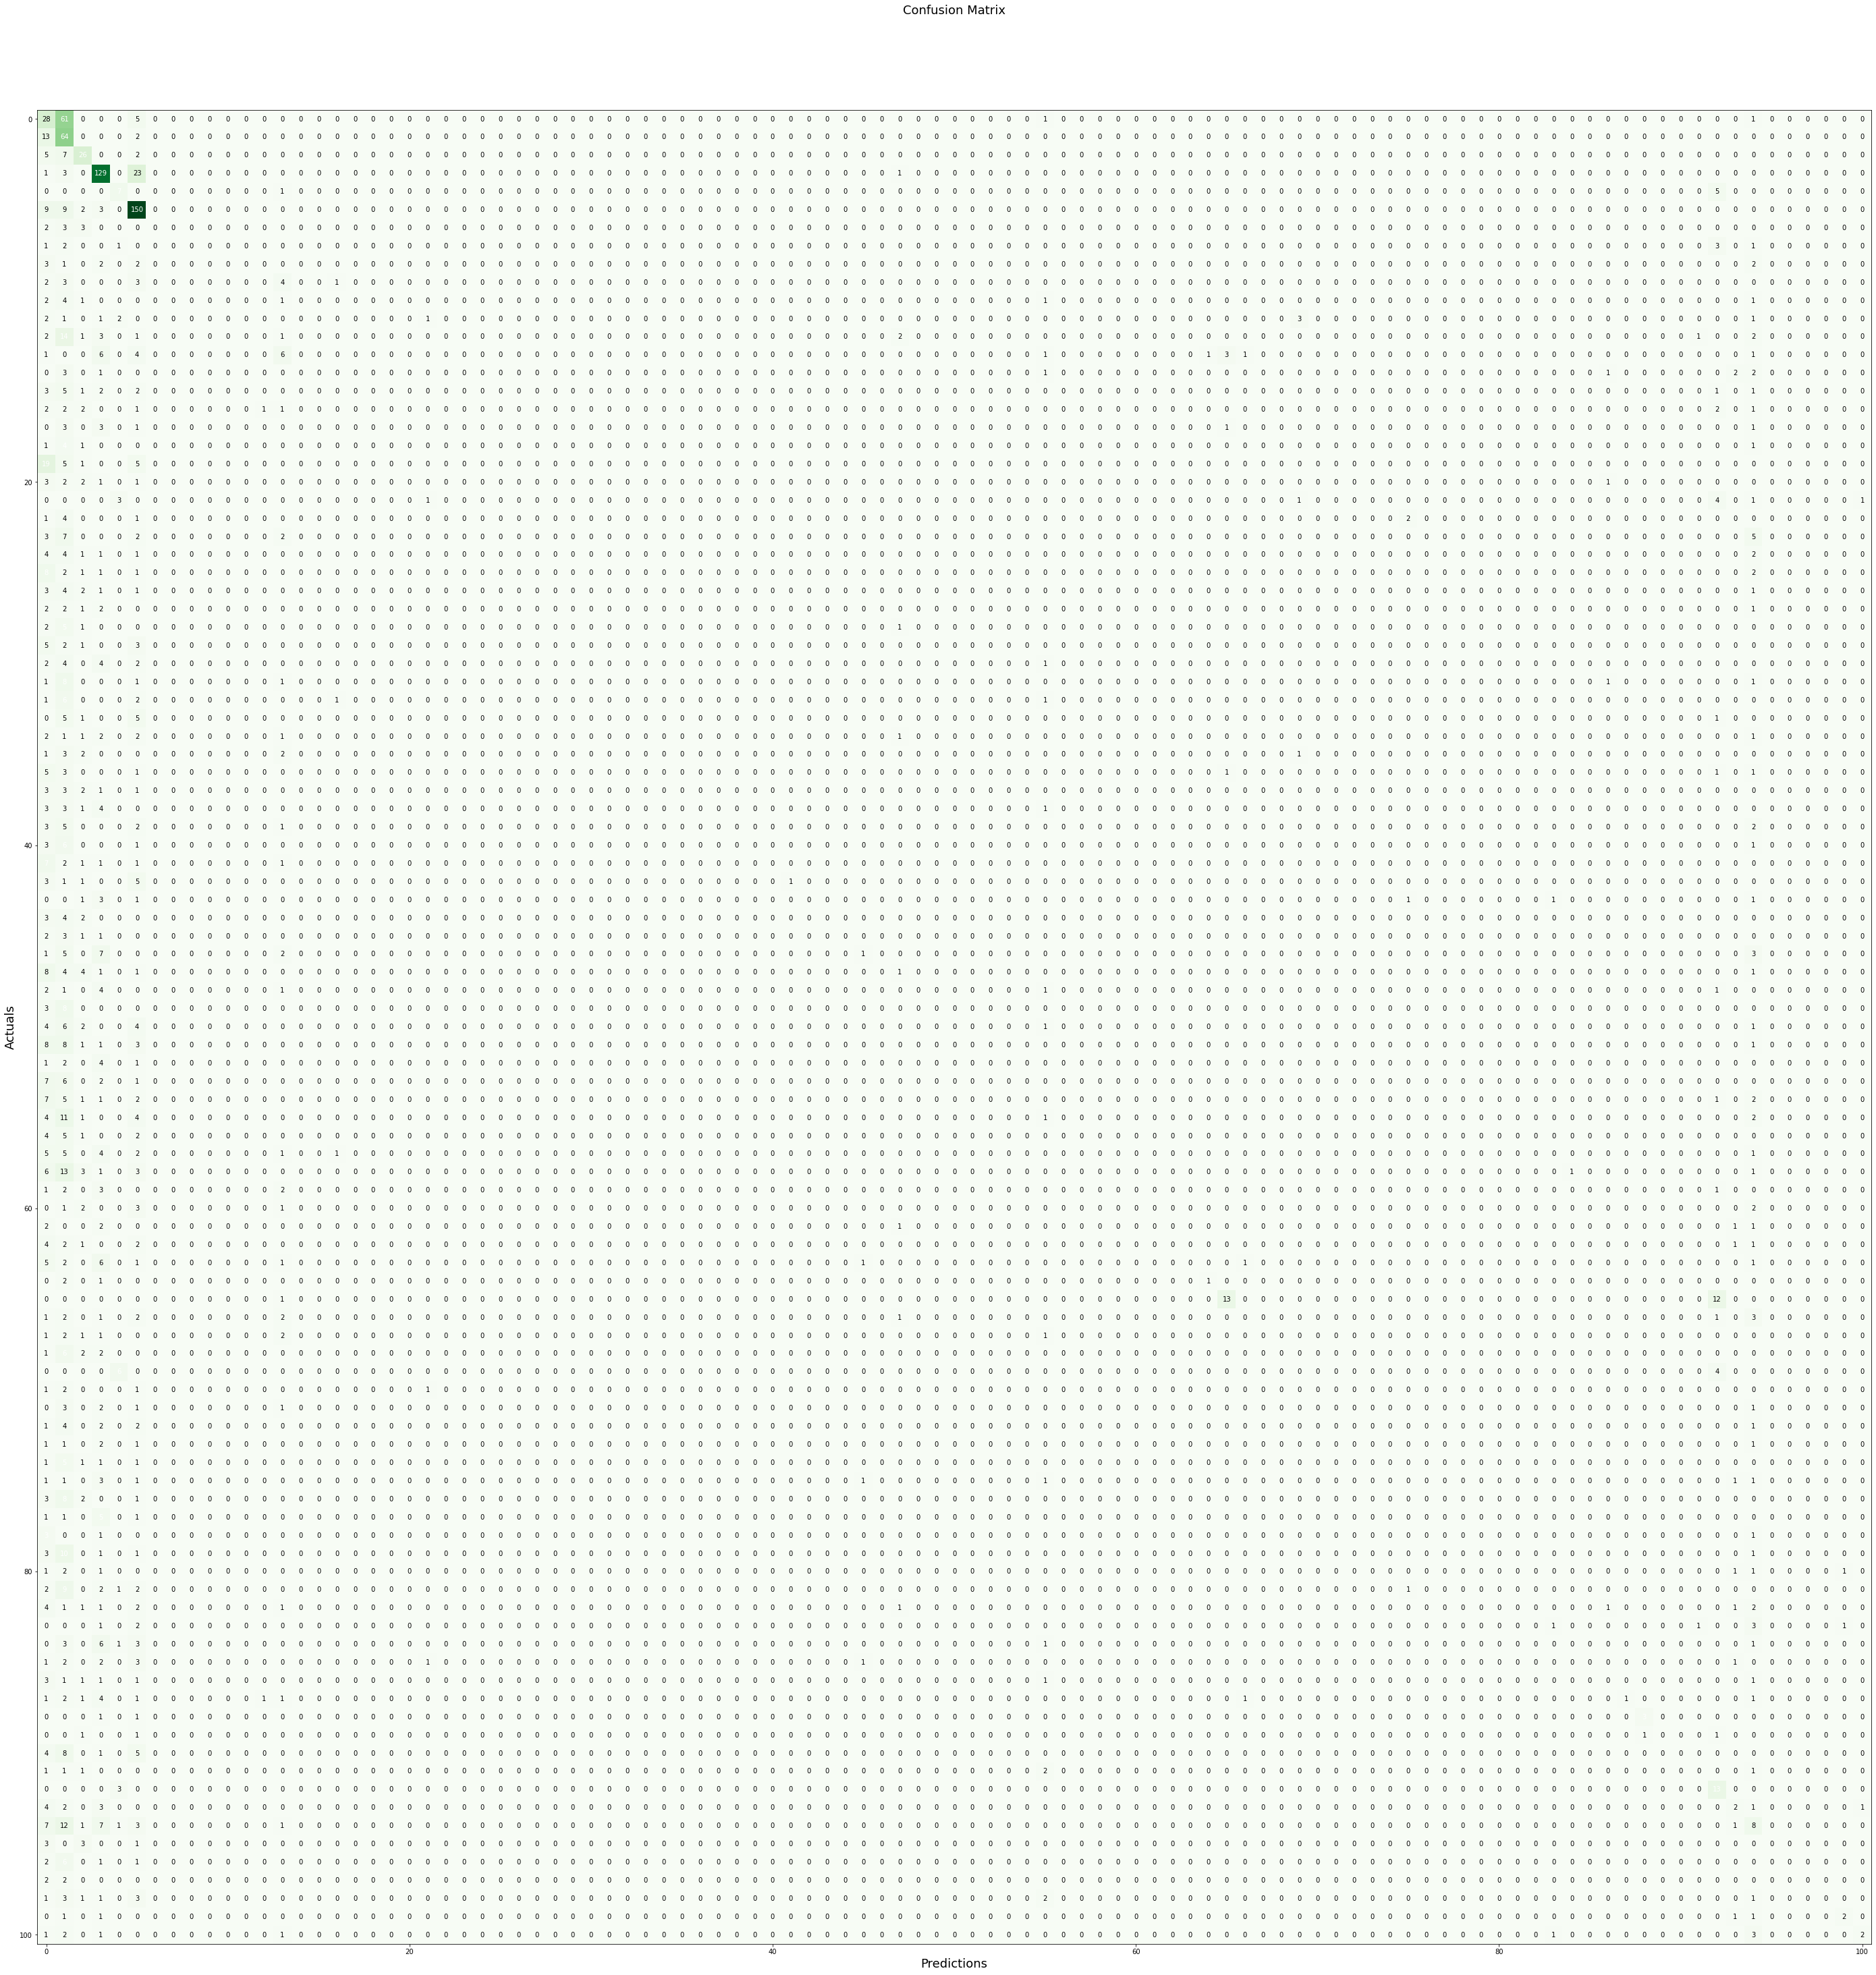

In [24]:
import matplotlib.pyplot as plt
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, figsize=(50, 50), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Yêu cầu 4: 
- Áp dụng thuật toán SVC (với tham số C=1)
- Sử dụng chiến lược 1 vs rest:
  + Tính Accuracy cho tập test
  + Tính số support vector
  + Tính và hiển thị ma trận Confusion


Accuracy tập test

In [25]:
svc = SVC(C=1,decision_function_shape='ovr')
svc.fit(x_train,y_train)
accuracy = svc.score(x_test,y_test)
print("Test Accuracy:",  accuracy)

Test Accuracy: 0.2523041474654378


Số support vector

In [26]:
print("Numbers of Support Vector: ", len(svc.support_vectors_))

Numbers of Support Vector:  4853


Confusion Matrix

In [27]:
y_pred_val = svc_ovo.predict(x_val)
print(metrics.confusion_matrix(y_val, y_pred_val))

[[28 61  0 ...  0  0  0]
 [13 64  0 ...  0  0  0]
 [ 5  7 26 ...  0  0  0]
 ...
 [ 1  3  1 ...  0  0  0]
 [ 0  1  0 ...  0  2  0]
 [ 1  2  0 ...  0  0  2]]


In [28]:
confusion_matrix = metrics.confusion_matrix(y_val, y_pred_val)

In [29]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

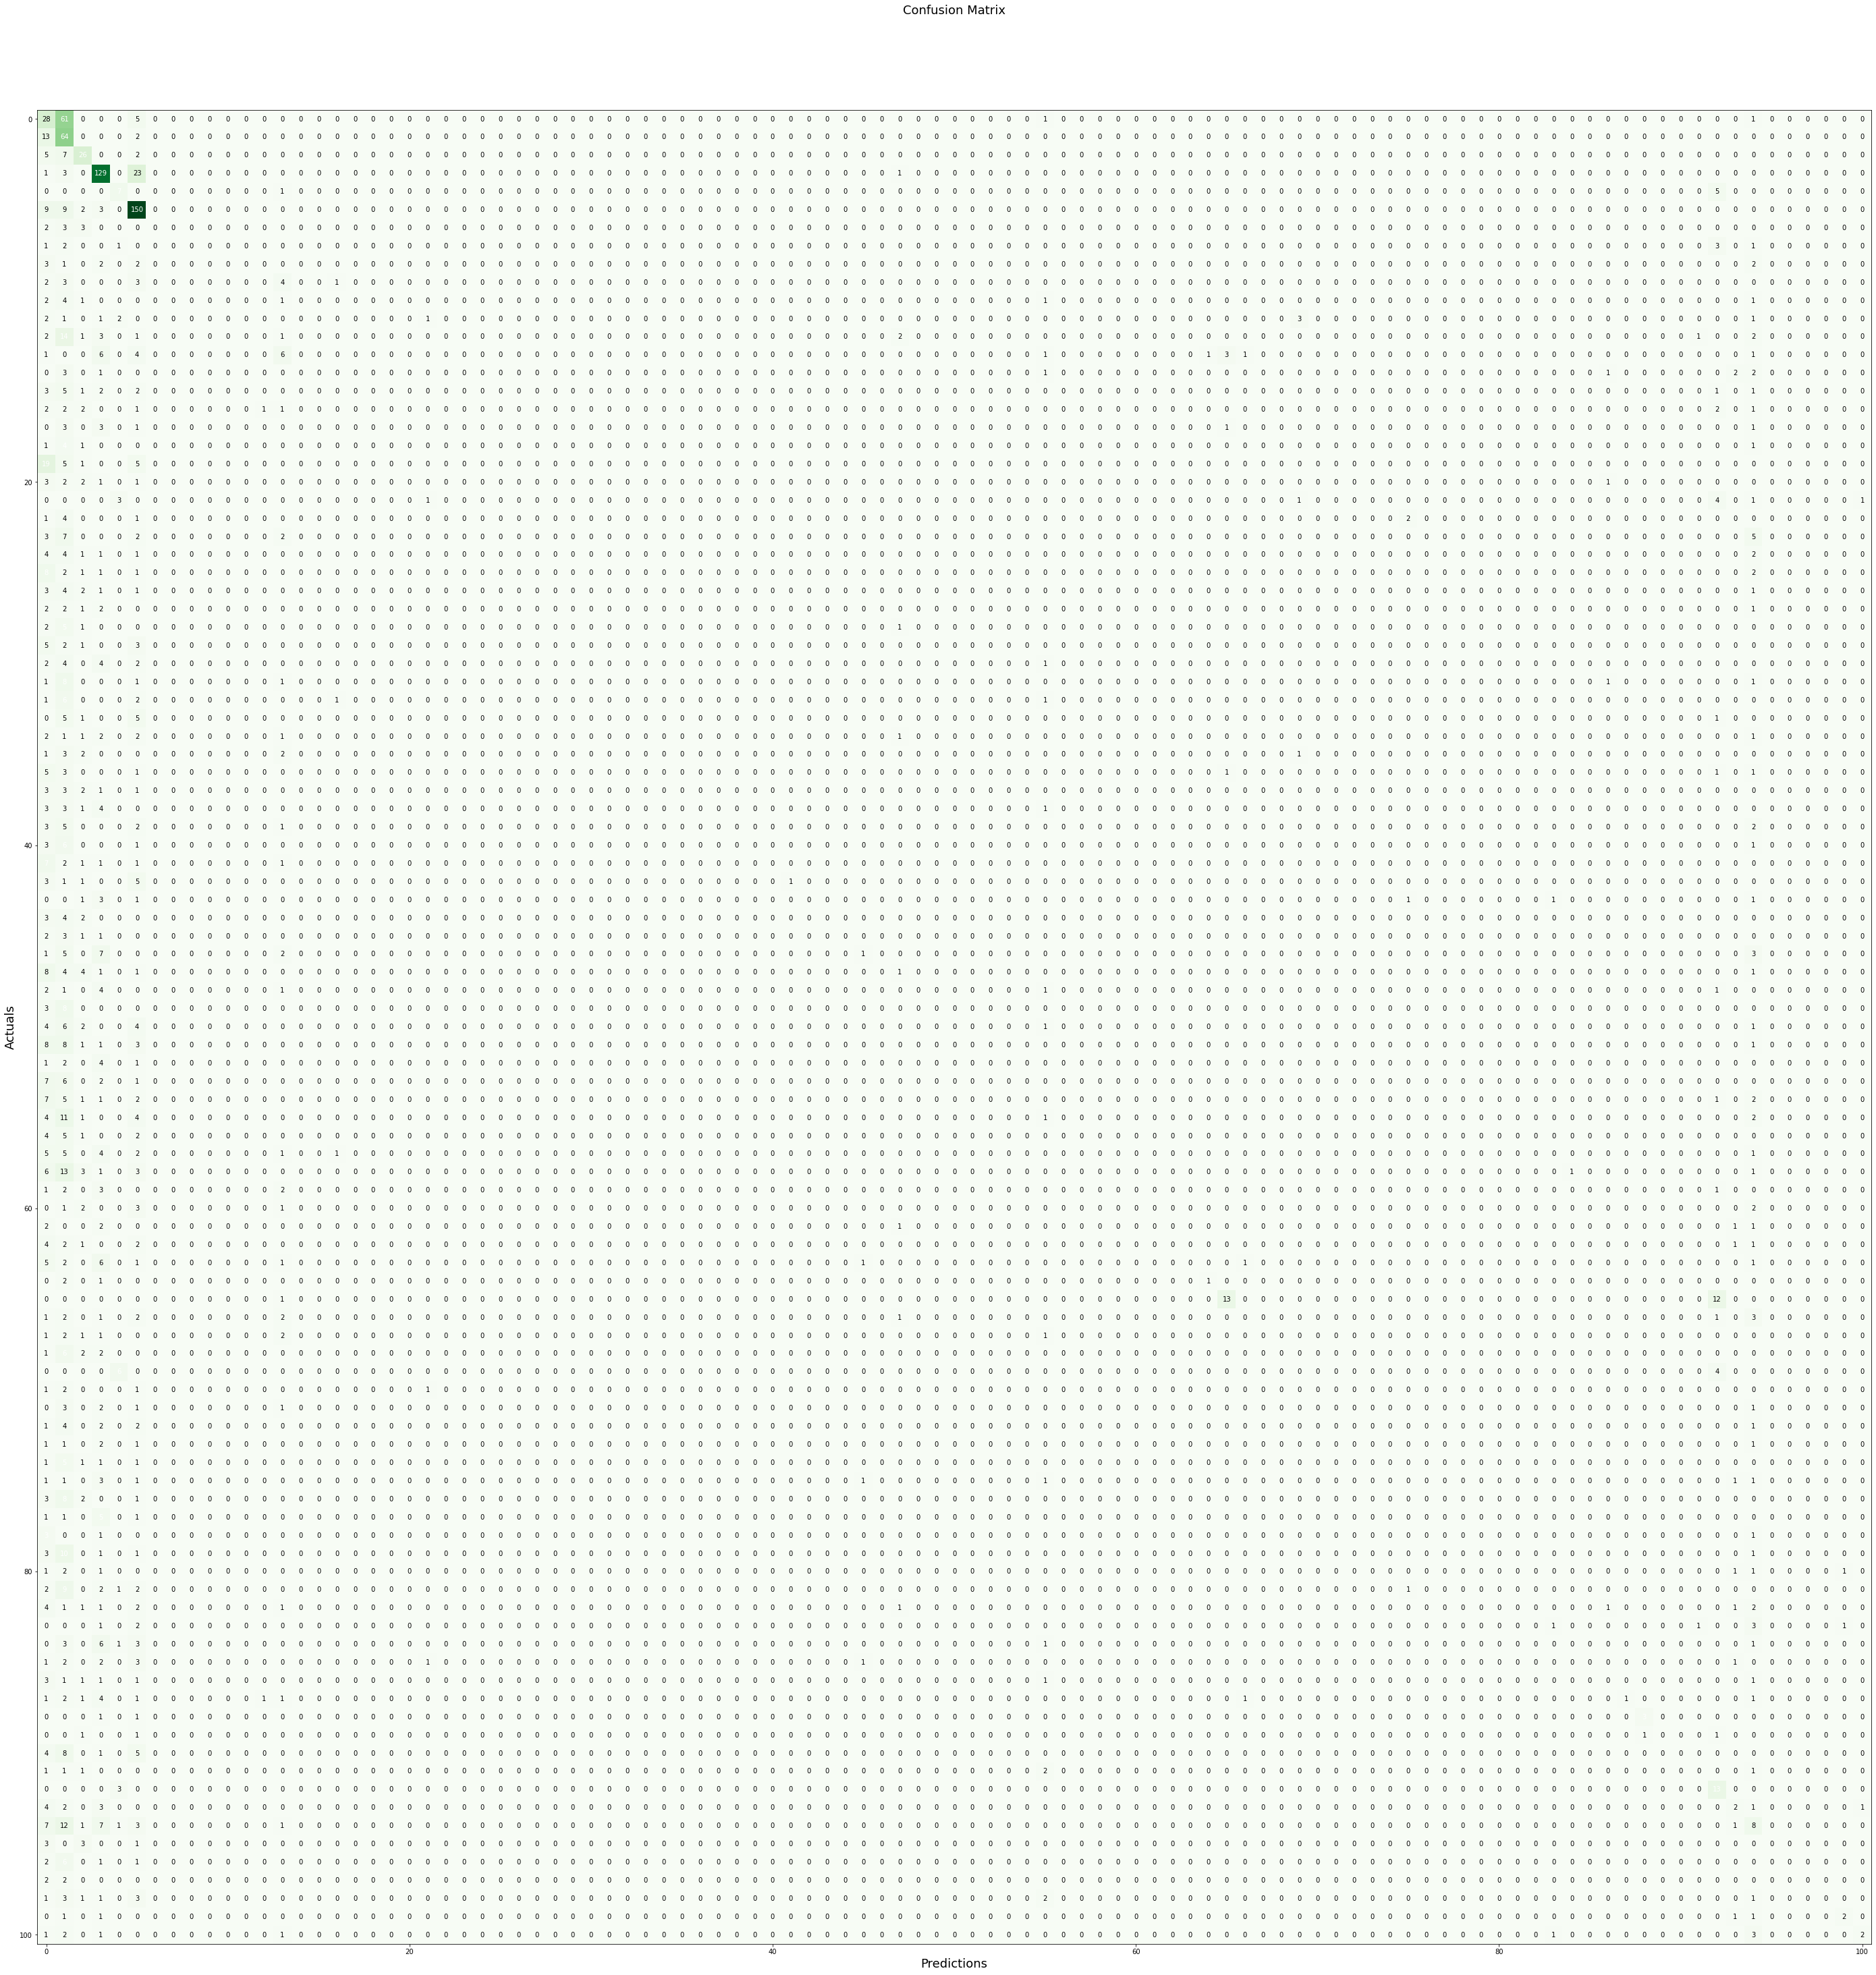

In [30]:
import matplotlib.pyplot as plt
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, figsize=(50, 50), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()